# MMA Fighter 2 Tactics/Method Analysis (MLDLC)

MLDLC structure:
1. Business/Goal: summarize Fighter 2 tactics and style from event logs.
2. Data Understanding: inspect event distribution, duration, and data quality.
3. Data Preparation: derive temporal and tactical features.
4. Modeling (optional): prepare features for next-move prediction.
5. Evaluation: compare baselines and report metrics.
6. Deployment: apply to new videos for real-time feedback.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 50)

In [12]:
data_path = "fighter_F1_events.csv"
df = pd.read_csv(data_path)
df = df.sort_values("timestamp").reset_index(drop=True)

# Boxing-only: remove kick actions
df = df[~df["action_type"].isin(["kick_low", "kick_high"])].reset_index(drop=True)
df.head(10)

,timestamp,action_type,hand_speed,leg_speed,movement_intensity
0,0.000000,guard_position,0.711112,0.555615,0.633364
1,1.098494,punch_left,1.516660,0.349821,0.933241
2,1.198357,backward_movement,0.767189,0.688498,0.727844
3,1.298220,guard_position,0.318751,0.409614,0.364182
4,2.097125,forward_movement,0.835481,0.781029,0.808255
5,2.496578,guard_position,0.665707,0.839191,0.752449
6,2.696304,backward_movement,0.793735,0.679819,0.736777
7,2.896030,guard_position,0.820611,0.545574,0.683092
8,2.995893,punch_right,1.249865,0.138142,0.694004
9,3.095756,guard_position,0.589508,0.386170,0.487839


In [13]:
df.tail(10)

,timestamp,action_type,hand_speed,leg_speed,movement_intensity
103,31.357015,guard_position,0.560522,0.368770,0.464646
104,31.456878,punch_right,1.536016,0.829181,1.182598
105,31.556741,guard_position,0.648467,0.470467,0.559467
106,31.756468,punch_right,1.439785,0.734109,1.086947
107,31.856331,guard_position,0.135275,0.655593,0.395434
108,31.956194,punch_right,1.515993,1.084123,1.300058
109,32.255783,backward_movement,0.476997,0.917584,0.697290
110,32.355646,guard_position,0.867134,0.656137,0.761636
111,32.555373,guard_position,0.639267,0.992178,0.815722
112,32.755099,guard_position,0.229883,0.363639,0.296761


In [14]:
duration_s = df["timestamp"].max() - df["timestamp"].min()
num_events = len(df)
action_counts = df["action_type"].value_counts()

duration_s, num_events, action_counts

(np.float64(32.75509871414441),
 113,
 action_type
 guard_position       60
 forward_movement     14
 punch_left           13
 backward_movement    13
 punch_right          13
 Name: count, dtype: int64)

In [15]:
df.isnull().sum()


timestamp             0
action_type           0
hand_speed            0
leg_speed             0
movement_intensity    0
dtype: int64

In [16]:
df.describe()

,timestamp,hand_speed,leg_speed,movement_intensity
count,113.000000,113.000000,113.000000,113.000000
mean,18.019546,0.843740,0.636739,0.740240
std,9.595213,0.572468,0.390612,0.419452
min,0.000000,0.131971,0.060702,0.236598
25%,10.585489,0.392427,0.401063,0.440808
50%,17.775633,0.711112,0.545574,0.633364
75%,25.764681,1.161964,0.727651,0.890791
max,32.755099,2.737382,2.171719,2.408091


In [17]:
df.info()

action_counts

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   timestamp           113 non-null    float64
 1   action_type         113 non-null    object 
 2   hand_speed          113 non-null    float64
 3   leg_speed           113 non-null    float64
 4   movement_intensity  113 non-null    float64
dtypes: float64(4), object(1)
memory usage: 4.5+ KB


action_type
guard_position       60
forward_movement     14
punch_left           13
backward_movement    13
punch_right          13
Name: count, dtype: int64

In [8]:
# Feature engineering + model comparison (time-series, no leakage)
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

df_model = df.copy()
df_model["next_action"] = df_model["action_type"].shift(-1)
df_model["dt"] = df_model["timestamp"].diff().fillna(0)

action_labels = sorted(df_model["action_type"].unique())
for action in action_labels:
    df_model[f"act_{action}"] = (df_model["action_type"] == action).astype(int)

def build_features(window_size: int):
    rolling_cols = ["hand_speed", "leg_speed", "movement_intensity", "dt"]
    rolling_mean = df_model[rolling_cols].rolling(window_size).mean().add_suffix("_mean")
    rolling_std = df_model[rolling_cols].rolling(window_size).std().fillna(0).add_suffix("_std")
    rolling_counts = df_model[[f"act_{a}" for a in action_labels]].rolling(window_size).sum().add_suffix("_count")
    feature_df = pd.concat([
        df_model[["action_type"]],
        rolling_mean,
        rolling_std,
        rolling_counts,
    ], axis=1)
    feature_df = feature_df.dropna().reset_index(drop=True)
    labels = df_model.loc[feature_df.index, "next_action"].reset_index(drop=True)
    return feature_df, labels

def train_eval(feature_df, labels):
    split_idx = int(len(feature_df) * 0.7)
    X_train = feature_df.iloc[:split_idx].copy()
    X_test = feature_df.iloc[split_idx:].copy()
    y_train = labels.iloc[:split_idx]
    y_test = labels.iloc[split_idx:]

    # Baseline 1: Most frequent class
    most_freq = y_train.value_counts().idxmax()
    y_pred_most = [most_freq] * len(y_test)

    # Baseline 2: Markov (current action -> most likely next action)
    transitions = pd.crosstab(
        df_model.loc[:split_idx, "action_type"],
        df_model.loc[:split_idx, "next_action"],
).fillna(0)
    transitions = transitions.div(transitions.sum(axis=1), axis=0).fillna(0)
    markov_default = y_train.value_counts().idxmax()
    y_pred_markov = []
    for current_action in X_test["action_type"]:
        if current_action in transitions.index and transitions.loc[current_action].sum() > 0:
            y_pred_markov.append(transitions.loc[current_action].idxmax())
        else:
            y_pred_markov.append(markov_default)

    # Model 1: Logistic Regression (class-weighted)
    X_train_lr = X_train.drop(columns=["action_type"])
    X_test_lr = X_test.drop(columns=["action_type"])
    lr = LogisticRegression(max_iter=2000, multi_class="multinomial", class_weight="balanced")
    lr.fit(X_train_lr, y_train)
    y_pred_lr = lr.predict(X_test_lr)

    # Model 2: Random Forest (class-weighted)
    rf = RandomForestClassifier(n_estimators=400, random_state=42, class_weight="balanced")
    rf.fit(X_train_lr, y_train)
    y_pred_rf = rf.predict(X_test_lr)

    results = pd.DataFrame(
        {
            "model": ["MostFrequent", "Markov", "LogReg_bal", "RandomForest_bal"],
            "accuracy": [
                accuracy_score(y_test, y_pred_most),
                accuracy_score(y_test, y_pred_markov),
                accuracy_score(y_test, y_pred_lr),
                accuracy_score(y_test, y_pred_rf),
            ],
            "macro_f1": [
                f1_score(y_test, y_pred_most, average="macro"),
                f1_score(y_test, y_pred_markov, average="macro"),
                f1_score(y_test, y_pred_lr, average="macro"),
                f1_score(y_test, y_pred_rf, average="macro"),
            ],
        }
)
    return results, (X_train_lr, X_test_lr, y_train, y_test, y_pred_lr, y_pred_rf, lr, rf)

# Window size sweep (helps with tactics pattern length)
window_candidates = [3, 5, 10, 15]
sweep_rows = []
best_bundle = None
best_results = None
best_window = None
best_score = -1.0

for w in window_candidates:
    feat_df, labels = build_features(w)
    res, bundle = train_eval(feat_df, labels)
    best_row = res.sort_values("macro_f1", ascending=False).iloc[0]
    sweep_rows.append({"window": w, "best_model": best_row["model"], "macro_f1": best_row["macro_f1"], "accuracy": best_row["accuracy"]})
    if best_row["macro_f1"] > best_score:
        best_score = best_row["macro_f1"]
        best_bundle = bundle
        best_results = res
        best_window = w

sweep_df = pd.DataFrame(sweep_rows).sort_values("macro_f1", ascending=False)
sweep_df

c:\Users\Admin\Desktop\GitHub\MMA-AI\MMA\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Admin\Desktop\GitHub\MMA-AI\MMA\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Admin\Desktop\GitHub\MMA-AI\MMA\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Admin\Desktop\GitHub\MMA-AI\MMA\lib\site-packages\sklearn\linear_model\_logisti

,window,best_model,macro_f1,accuracy
0,3,LogReg_bal,0.392882,0.441176
1,5,LogReg_bal,0.277778,0.333333
2,10,LogReg_bal,0.240380,0.281250
3,15,LogReg_bal,0.197333,0.233333


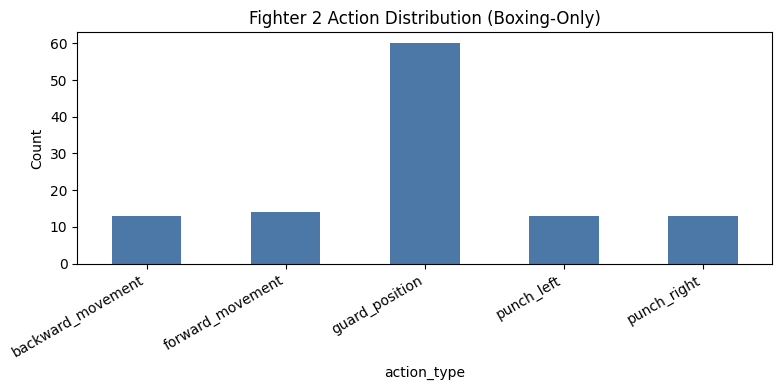

C:\Users\Admin\AppData\Local\Temp\ipykernel_12364\1164653478.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  attack_by_bin = df.groupby("time_bin")["is_attack"].sum()


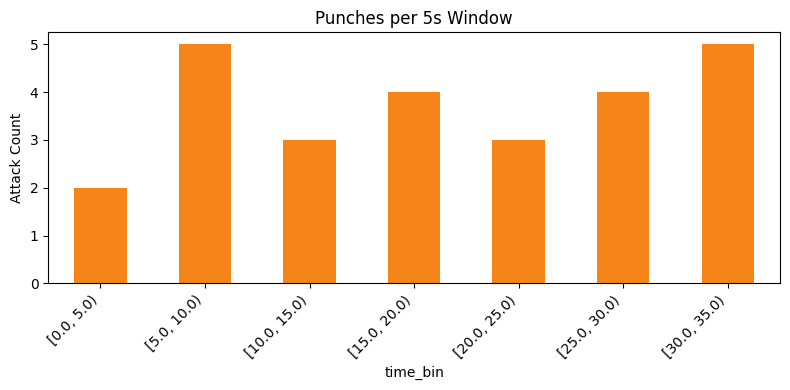

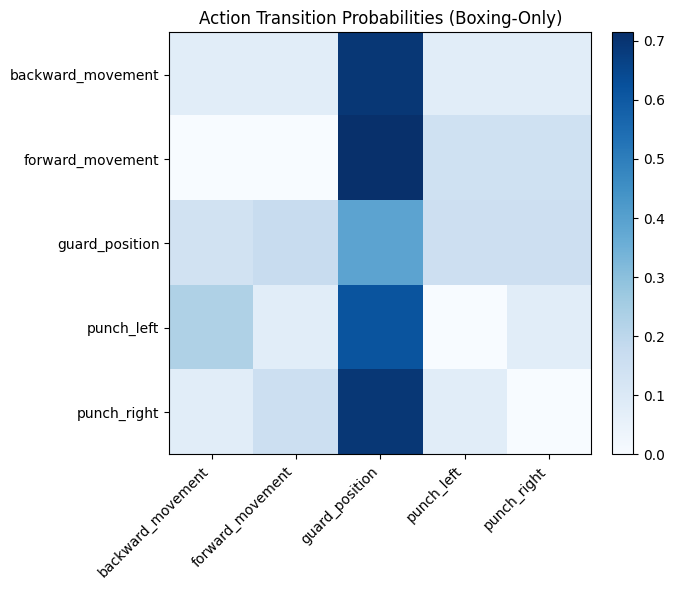

'punch-heavy, defensive'

In [9]:
attack_actions = ["punch_left", "punch_right"]
movement_actions = ["forward_movement", "backward_movement"]

df["dt"] = df["timestamp"].diff().fillna(0)
df["is_attack"] = df["action_type"].isin(attack_actions)
df["is_defense"] = df["action_type"].eq("guard_position")
df["is_movement"] = df["action_type"].isin(movement_actions)
df["attack_type"] = np.select(
    [df["action_type"].isin(["punch_left", "punch_right"])],
    ["punch"],
    default="other",
)

duration_min = max(duration_s / 60.0, 1e-6)
attack_count = int(df["is_attack"].sum())
punch_count = int((df["attack_type"] == "punch").sum())
guard_count = int(df["is_defense"].sum())
move_count = int(df["is_movement"].sum())
forward_count = int((df["action_type"] == "forward_movement").sum())
backward_count = int((df["action_type"] == "backward_movement").sum())
forward_ratio = forward_count / max(forward_count + backward_count, 1)

tactical_summary = {
    "duration_min": duration_min,
    "events": num_events,
    "attack_per_min": attack_count / duration_min,
    "punch_ratio": punch_count / max(attack_count, 1),
    "guard_ratio": guard_count / max(num_events, 1),
    "movement_ratio": move_count / max(num_events, 1),
    "forward_ratio": forward_ratio,
    "avg_hand_speed": float(df["hand_speed"].mean()),
    "avg_leg_speed": float(df["leg_speed"].mean()),
    "avg_intensity": float(df["movement_intensity"].mean()),
}

pd.Series(tactical_summary)

plt.figure(figsize=(8, 4))
action_counts.reindex(sorted(action_counts.index)).plot(kind="bar", color="#4C78A8")
plt.title("Fighter 2 Action Distribution (Boxing-Only)")
plt.ylabel("Count")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

bin_size_s = 5
bins = np.arange(df["timestamp"].min(), df["timestamp"].max() + bin_size_s, bin_size_s)
df["time_bin"] = pd.cut(df["timestamp"], bins=bins, right=False)
attack_by_bin = df.groupby("time_bin")["is_attack"].sum()

plt.figure(figsize=(8, 4))
attack_by_bin.plot(kind="bar", color="#F58518")
plt.title(f"Punches per {bin_size_s}s Window")
plt.ylabel("Attack Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

df["next_action"] = df["action_type"].shift(-1)
transition_counts = pd.crosstab(df["action_type"], df["next_action"])
transition_probs = transition_counts.div(transition_counts.sum(axis=1), axis=0).fillna(0)

transition_probs

fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(transition_probs.values, cmap="Blues")
ax.set_xticks(range(len(transition_probs.columns)))
ax.set_yticks(range(len(transition_probs.index)))
ax.set_xticklabels(transition_probs.columns, rotation=45, ha="right")
ax.set_yticklabels(transition_probs.index)
ax.set_title("Action Transition Probabilities (Boxing-Only)")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

style = []
if tactical_summary["punch_ratio"] > 0.6:
    style.append("punch-heavy")
else:
    style.append("balanced offense")

if tactical_summary["guard_ratio"] > 0.3:
    style.append("defensive")
if tactical_summary["movement_ratio"] > 0.3:
    style.append("mobile")

style_profile = ", ".join(style)
style_profile

Best window: 3
              model  accuracy  macro_f1
2        LogReg_bal  0.441176  0.392882
3  RandomForest_bal  0.352941  0.161905
1            Markov  0.529412  0.138462
0      MostFrequent  0.529412  0.138462
Best model: LogReg_bal
                   precision    recall  f1-score   support

backward_movement      0.000     0.000     0.000         2
 forward_movement      0.500     1.000     0.667         4
   guard_position      1.000     0.111     0.200        18
       punch_left      0.400     1.000     0.571         4
      punch_right      0.385     0.833     0.526         6

         accuracy                          0.441        34
        macro avg      0.457     0.589     0.393        34
     weighted avg      0.703     0.441     0.344        34



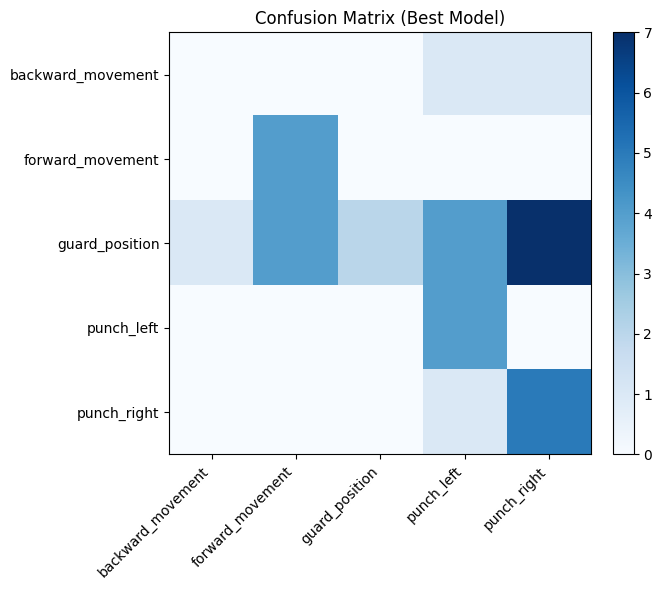

In [10]:
# Detailed evaluation for the best window + model
X_train_lr, X_test_lr, y_train, y_test, y_pred_lr, y_pred_rf, lr, rf = best_bundle
results = best_results
print("Best window:", best_window)
print(results.sort_values("macro_f1", ascending=False))

best_model_name = results.sort_values("macro_f1", ascending=False).iloc[0]["model"]
if best_model_name == "RandomForest_bal":
    best_pred = y_pred_rf
elif best_model_name == "LogReg_bal":
    best_pred = y_pred_lr
elif best_model_name == "Markov":
    # Recompute Markov for the chosen window using latest split
    most_freq = y_train.value_counts().idxmax()
    transitions = pd.crosstab(df_model.loc[:len(y_train), "action_type"], df_model.loc[:len(y_train), "next_action"]).fillna(0)
    transitions = transitions.div(transitions.sum(axis=1), axis=0).fillna(0)
    best_pred = []
    for current_action in df_model.loc[len(y_train):, "action_type"].iloc[:len(y_test)]:
        if current_action in transitions.index and transitions.loc[current_action].sum() > 0:
            best_pred.append(transitions.loc[current_action].idxmax())
        else:
            best_pred.append(most_freq)
else:
    best_pred = [y_train.value_counts().idxmax()] * len(y_test)

print("Best model:", best_model_name)
print(classification_report(y_test, best_pred, digits=3))

cm = confusion_matrix(y_test, best_pred, labels=action_labels)
fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(cm, cmap="Blues")
ax.set_xticks(range(len(action_labels)))
ax.set_yticks(range(len(action_labels)))
ax.set_xticklabels(action_labels, rotation=45, ha="right")
ax.set_yticklabels(action_labels)
ax.set_title("Confusion Matrix (Best Model)")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

if best_model_name == "RandomForest_bal":
    importances = pd.Series(rf.feature_importances_, index=X_train_lr.columns)
    top_importances = importances.sort_values(ascending=False).head(12)

    plt.figure(figsize=(8, 4))
    top_importances.sort_values().plot(kind="barh", color="#54A24B")
    plt.title("Top Feature Importances (Random Forest)")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

    top_importances